Dataset generation 1

$Y = 0.8X_1 + 0.1X_2 + \mathcal{N}(0, 0.5+ \frac{X_1 + X_2}{2})$

with $X_1,X_2 \sim B(2,2)$

Dataset generation 2

$Y = 0.5\sin{(2\pi X_1)} + 0.2X_2 + \mathcal{N}(0, 0.1 + 0.4X_1)$

with $X_1,X_2 \sim B(1,3)$

Dataset generation 3

$Y = \sqrt{X_1^2+X_2^2} + X_1 + \mathcal{N}(0, 0.6+ 0.5X_2^2)$

with $X_1,X_2 \sim B(2,3)$

In [1]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.stats import norm



def compute_qhat_CQR(y_pred_lower, y_pred_upper, y_true, alpha):
    
    first_aux = np.array(y_pred_lower) - np.array(y_true)
    second_aux = np.array(y_true) - np.array(y_pred_upper)
    
    non_conformity_scores = np.maximum(first_aux, second_aux)
    qhat = np.quantile(non_conformity_scores, 1-alpha)
    
    return qhat


def compute_iou(interval1, interval2):
    # Calculate the intersection of the intervals
    intersection_start = max(abs(interval1[0]), abs(interval2[0]))
    intersection_end = min(abs(interval1[1]), abs(interval2[1]))

    # Check if the intervals overlap
    if intersection_start > intersection_end:
        return 0.0  # Intervals do not overlap

    # Calculate the lengths of the intervals
    length_interval1 = abs(interval1[1]) - abs(interval1[0])
    length_interval2 = abs(interval2[1]) - abs(interval2[0])

    # Calculate the length of the intersection
    length_intersection = intersection_end - intersection_start

    # Compute the IoU
    iou = length_intersection / (length_interval1 + length_interval2 - length_intersection)
    return iou

def compute_iou_test(lower_bound, upper_bound, ground_truth_PIs):
    
    iou_list = []
    
    for i in range(len(lower_bound)):
        iou_list.append(compute_iou(ground_truth_PIs[i], [lower_bound[i],upper_bound[i]]))
    
    return np.mean(iou_list)
    

def train_cal_test_split(X, y, train_size, cal_size):
    n = X.shape[0]
    n1 = int(X.shape[0] * train_size)
    n2 = int(X.shape[0] * cal_size)

        
    X_train = X[:n1]
    X_cal = X[n1:n1+n2]
    X_test = X[n1+n2:]
    
    y_train = y[:n1]
    y_cal = y[n1:n1+n2]
    y_test = y[n1+n2:]
    
    return X_train, y_train, X_cal, y_cal, X_test, y_test, (n1,n2)

def compute_coverage(y_lower_arr, y_upper_arr, y_true_arr):
    count = 0
    
    for i in range(len(y_true_arr)):
        if y_lower_arr[i] < y_true_arr[i] and y_true_arr[i] < y_upper_arr[i]:
            count+=1
    
    return count/len(y_true_arr)


def permutation_importance(model_lower, model_upper, X_cal, y_cal, n_repeats):
    lower_bound = model_lower.predict(X_cal)
    upper_bound = model_upper.predict(X_cal)
    baseline_coverage = compute_coverage(lower_bound, upper_bound, y_cal)
    
    permutation_importances = np.zeros(X_cal.shape[1])
    
    for j in range(X_cal.shape[1]):
        aux = np.zeros(n_repeats)
        
        for i in range(n_repeats):
            
            X_cal_permuted = X_cal.copy()  # Create a copy to preserve the original array
            X_cal_permuted[:, j] = np.random.permutation(X_cal_permuted[:, j])
            
            lower_bound = model_lower.predict(X_cal_permuted)
            upper_bound = model_upper.predict(X_cal_permuted)
            permuted_coverage = compute_coverage(lower_bound, upper_bound, y_cal)
            aux[i] = np.abs(baseline_coverage - permuted_coverage)
        
        permutation_importances[j] = np.mean(aux)
        
    return permutation_importances


def optimized_kmeans(X_cal,desired_variance,feature_importance):
    
    scores=[]
    
    mean_point = np.mean(X_cal*feature_importance,axis=0)
    SSE = np.sum((X_cal*feature_importance-mean_point)**2)
    i=1
    
    variance=0
    
    while variance < desired_variance:
        
        km = KMeans(n_clusters=i+1, random_state=0, n_init = 10).fit(X_cal*feature_importance)
        
        centroids = km.cluster_centers_
        
        clusters = km.labels_
        
        SSE_between=0
        
        for j in range(len(np.unique(clusters))):
            n_k = X_cal[clusters==j,:].shape[0]
            
            SSE_between+= n_k*np.sum((centroids[j]-mean_point)**2)
        
        variance = SSE_between/SSE
        
        scores.append([i+1,variance])
        i+=1
    
    scores = np.array(scores)
    
    best_k = i
    plt.axvline(x=best_k, color='r', linestyle='--')
    plt.plot(scores[:,0],scores[:,1])
    plt.xlabel('#clusters')
    plt.ylabel('Explained variance')
    plt.show()
    
    km =  KMeans(n_clusters=i, random_state=0, n_init = 100).fit(X_cal*feature_importance)
    
    return km,best_k


def compute_qhat_ICQR(model_lower, model_upper, X_cal, y_cal, desired_variance, alpha=0.1):
    
    lower_bound = model_lower.predict(X_cal)
    upper_bound = model_upper.predict(X_cal)
    
    feature_importance = permutation_importance(model_lower, model_upper, X_cal, y_cal, 100)
    km,best_k=optimized_kmeans(X_cal, desired_variance, feature_importance)
    
    nrows = X_cal.shape[0]
    clusters = km.predict(X_cal*feature_importance)

    scores=[]
    qhats = np.zeros(best_k)

    for i in range(best_k):
        scores.append([])

    for i in range(nrows):
        scores[clusters[i]].append(max(lower_bound[i]-y_cal[i],y_cal[i]-upper_bound[i]))


    for i in range(best_k):
        N = len(scores[i])
        
        if N>0:
            qhats[i] = np.quantile(scores[i],1-alpha)
    
    return qhats,km, feature_importance

def true_function1(X):
    return 0.8 * X[:,0] + 0.1 * X[:,1]

def true_function1_index(X, i):
    return 0.8 * X[i,0] + 0.1 * X[i,1]

def true_function2(X):
    return 0.5 * np.sin(2 * np.pi * X[:, 0]) + 0.2 * X[:, 1]

def true_function2_index(X, i):
    return 0.5 * np.sin(2 * np.pi * X[i, 0]) + 0.2 * X[i, 1]

def true_function3(X):
    return np.sqrt(X[:, 0]**2+X[:, 1]**2) + X[:,0]

def true_function3_index(X, i):
    return np.sqrt(X[i,0]**2+X[i,1]**2) + X[i,0]


    



In [2]:
import numpy as np

n = 100000
n_features = 2
alpha = 0.1

X = np.random.beta(2, 3, size=(n, n_features))
std_1 = 0.5 + (X[:, 0]+X[:, 1])/2
std_2 = 0.1 + 0.4 * X[:, 0]
std_3 = 0.6 + 0.5 * X[:, 1]**2

noise_1 = np.random.normal(loc=0, scale= std_1, size=(n,))
noise_2 = np.random.normal(loc=0, scale=std_2, size=(n,))
noise_3 = np.random.normal(loc=0, scale=std_3, size=(n,))


y = true_function3(X) + noise_3

mu_series = []
std_series = []

for i in range(n):
    mu_series.append(true_function3_index(X,i))
    std_series.append(std_3[i])
    
    

In [3]:
alpha = 0.01
coef = norm.ppf(1-alpha/2)

In [4]:
y = np.array(y)

In [5]:
X_train, y_train, X_cal, y_cal, X_test, y_test, (n1,n2) = train_cal_test_split(X, y, 0.01, 0.4)

In [6]:
model_lower = GradientBoostingRegressor(loss='quantile', alpha=alpha/2)
model_upper = GradientBoostingRegressor(loss='quantile', alpha=1-alpha/2)

model_lower.fit(X_train, y_train)
model_upper.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.995, loss='quantile')

In [7]:
lower_bound = model_lower.predict(X_test)
upper_bound = model_upper.predict(X_test)

In [8]:
compute_coverage(lower_bound, upper_bound, y_test)

0.9697457627118644

In [9]:
ground_truth_PIs = []

for i in range(len(X_test)):
    
    ground_truth_PIs.append([mu_series[n1+n2 +i] - coef* std_series[n1+n2 + i], mu_series[n1+n2 +i] + coef* std_series[n1+n2 + i]])
    

compute_iou_test(lower_bound, upper_bound, ground_truth_PIs)
    

0.684124563549514

In [10]:
lower_bound_cal = model_lower.predict(X_cal)
upper_bound_cal = model_upper.predict(X_cal)

In [11]:
qhat = compute_qhat_CQR(lower_bound_cal, upper_bound_cal, y_cal, alpha)
qhat

0.32686144008371876

In [12]:
lower_bound = model_lower.predict(X_test) - qhat
upper_bound = model_upper.predict(X_test) + qhat

In [13]:
compute_coverage(lower_bound, upper_bound, y_test)

0.9894745762711864

In [14]:
compute_iou_test(lower_bound, upper_bound, ground_truth_PIs)

0.7229016355668259

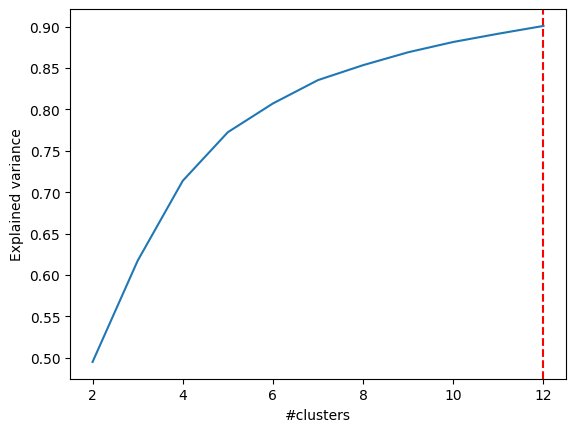

In [15]:
qhats,km, feature_importance = compute_qhat_ICQR(model_lower, model_upper, X_cal, y_cal, 0.9, alpha=alpha)

In [16]:
lower_bound = model_lower.predict(X_test)
upper_bound = model_upper.predict(X_test)
clusters_pred = km.predict(X_test * feature_importance)

for i in range(len(X_test)):
    lower_bound[i] = lower_bound[i] - qhats[clusters_pred[i]]
    upper_bound[i] = upper_bound[i] + qhats[clusters_pred[i]]

In [17]:
compute_iou_test(lower_bound, upper_bound, ground_truth_PIs)

0.7366571556538832

In [18]:
compute_coverage(lower_bound, upper_bound, y_test)

0.9892372881355932

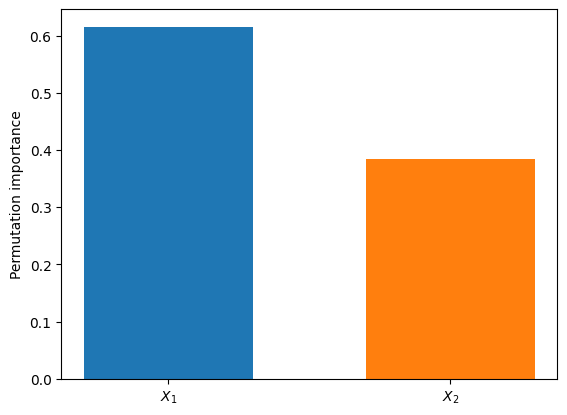

In [19]:
feature_importance = feature_importance/np.sum(feature_importance)
categorias = ['$X_1$', '$X_2$']
indice = [0,0.5]

plt.bar(0, feature_importance[0], width=0.3)
plt.bar(0.5, feature_importance[1], width=0.3)
plt.xticks(indice, categorias)
plt.ylabel('Permutation importance')

# Exibindo o gráfico
plt.show()